In [452]:
import os
import pandas as pd
from catboost import CatBoostClassifier, Pool, MetricVisualizer, cv
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import shap
import pickle
from sklearn.metrics import make_scorer, f1_score, auc, accuracy_score
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

In [295]:
file = 'data\База данных для конкурса.xls'
target = ['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']

In [296]:
def time_data(df, col):
    return_df = df.copy()
    v = pd.DatetimeIndex(df[col])
    return_df['Год'] = v.year
    return_df['Месяц'] = v.month
    return_df['День'] = v.day
    return_df.drop(col,axis=1,inplace=True)
    return return_df

In [297]:
def prepare_data(file):
    all_data = [pd.read_excel(file, sheet_name=x, index_col='ID') for x in range(11)]
    data_together = all_data[0]
    for x in range(1,len(all_data)):
        data_together = pd.concat((data_together,all_data[x]),axis=1)
    data_together = time_data(data_together, 'Дата рождения')
    data_together.drop('Профессия',axis=1,inplace=True)
    return data_together

In [298]:
all_data = prepare_data(file)

In [249]:
data_target = all_data[target]
data_train = all_data.drop(target,axis=1)

In [357]:
incorrect = []
correct = []
for x in data_train.columns:    
    try:
        CatBoostClassifier(verbose=False,iterations=1).fit(data_train[x], data_target[target[0]])
        correct.append(x)
    except:
        incorrect.append(x)

In [358]:
categorical_features = []
for x in (incorrect):
    try:
        CatBoostClassifier(verbose=False,iterations=1,cat_features=[0]).fit(data_train[x], data_target[target[0]])
        categorical_features.append(x)
    except:
        continue

In [359]:
correct = correct + categorical_features

In [360]:
correct = correct[:7] + correct[12:]

In [361]:
data_train = data_train[correct]

In [362]:
categorical_features = [list(data_train[correct].columns.values).index(x) for x in categorical_features]

In [371]:
data_train.loc[:,data_train.columns[categorical_features]] = data_train[data_train.columns[categorical_features]].astype(str)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [404]:
def train_test_data(df, target, categorical_features):
    train_x, test_x, train_y, test_y  = train_test_split(df,target,test_size = 0.3, random_state = 0)
    train_pool = Pool(
        data = train_x,
        label = train_y,
        cat_features = categorical_features
    )
    test_pool = Pool(
        data = test_x,
        label = test_y,
        cat_features = categorical_features
    )
    model = CatBoostClassifier(iterations=1500, custom_loss=['AUC', 'Accuracy'],eval_metric='AUC',
                               early_stopping_rounds=500,random_state = 0, task_type='GPU')
    model.fit(train_pool, eval_set = test_pool, verbose=False, plot=True)
    shap_values = model.get_feature_importance(
        test_pool,
        type ='ShapValues'
    )
    return model

## Тренировка модели и показвания зависимости наших предсказаний от наших данных

## Артериальная гипертензия

In [401]:
model = train_test_data(data_train,data_target[target[0]], categorical_features)
train_x, test_x, train_y, test_y  = train_test_split(data_train,data_target[target[0]],test_size = 0.3, random_state = 0)
train_pool = Pool(
    data = train_x,
    label = train_y,
    cat_features = categorical_features
)
pickle.dump(model, open(f'model_{target[0]}.pickle', 'wb'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [402]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)
shap.force_plot(explainer.expected_value, shap_values[0,:], train_x.iloc[0,:])

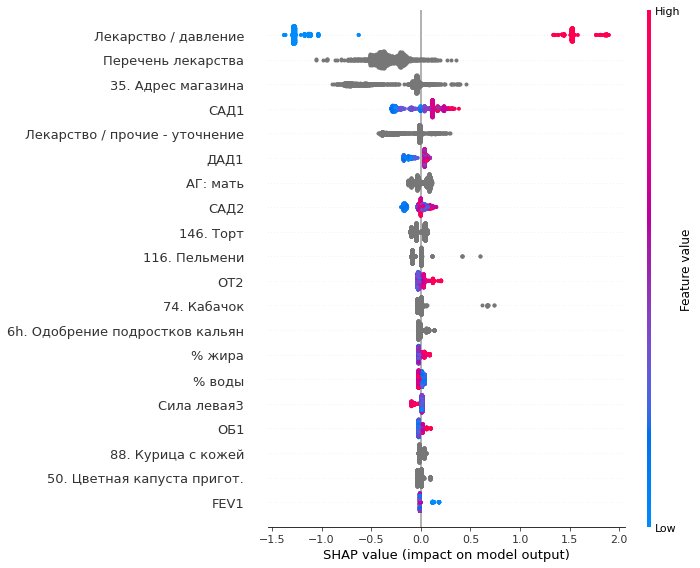

In [403]:
shap.summary_plot(shap_values, train_x)

## ОНМК

In [407]:
model = train_test_data(data_train,data_target[target[1]], categorical_features)
train_x, test_x, train_y, test_y  = train_test_split(data_train,data_target[target[1]],test_size = 0.3, random_state = 0)
train_pool = Pool(
    data = train_x,
    label = train_y,
    cat_features = categorical_features
)
pickle.dump(model, open(f'model_{target[1]}.pickle', 'wb'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [408]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)
shap.force_plot(explainer.expected_value, shap_values[0,:], train_x.iloc[0,:])

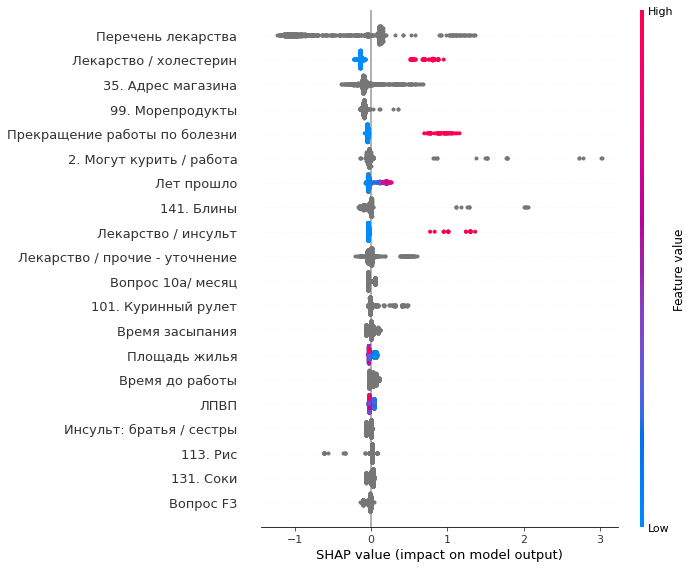

In [410]:
shap.summary_plot(shap_values, train_x)

## Стенокардия, ИБС, инфаркт миокарда

In [414]:
model = train_test_data(data_train,data_target[target[2]], categorical_features)
train_x, test_x, train_y, test_y  = train_test_split(data_train,data_target[target[2]],test_size = 0.3, random_state = 0)
train_pool = Pool(
    data = train_x,
    label = train_y,
    cat_features = categorical_features
)
pickle.dump(model, open(f'model_{target[2]}.pickle', 'wb'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [415]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)
shap.force_plot(explainer.expected_value, shap_values[0,:], train_x.iloc[0,:])

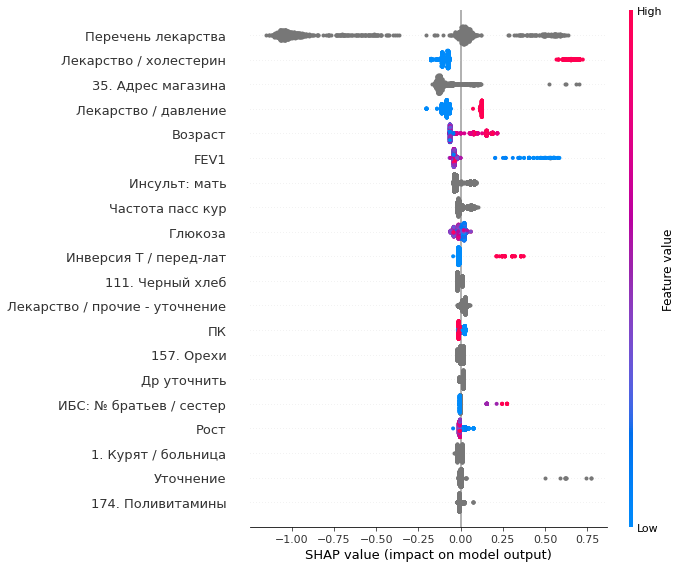

In [416]:
shap.summary_plot(shap_values, train_x)

## Сердечная недостаточность

In [417]:
model = train_test_data(data_train,data_target[target[3]], categorical_features)
train_x, test_x, train_y, test_y  = train_test_split(data_train,data_target[target[3]],test_size = 0.3, random_state = 0)
train_pool = Pool(
    data = train_x,
    label = train_y,
    cat_features = categorical_features
)
pickle.dump(model, open(f'model_{target[3]}.pickle', 'wb'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [418]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)
shap.force_plot(explainer.expected_value, shap_values[0,:], train_x.iloc[0,:])

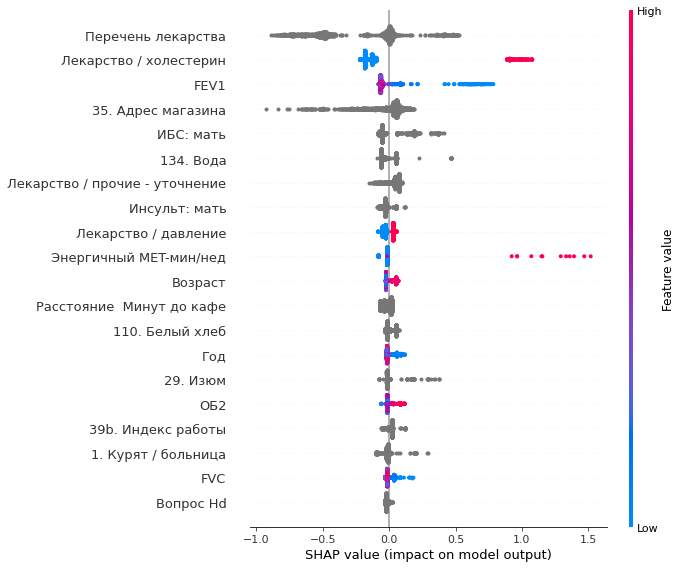

In [419]:
shap.summary_plot(shap_values, train_x)

## Прочие заболевания сердца

In [420]:
model = train_test_data(data_train,data_target[target[4]], categorical_features)
train_x, test_x, train_y, test_y  = train_test_split(data_train,data_target[target[4]],test_size = 0.3, random_state = 0)
train_pool = Pool(
    data = train_x,
    label = train_y,
    cat_features = categorical_features
)
pickle.dump(model, open(f'model_{target[4]}.pickle', 'wb'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [421]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)
shap.force_plot(explainer.expected_value, shap_values[0,:], train_x.iloc[0,:])

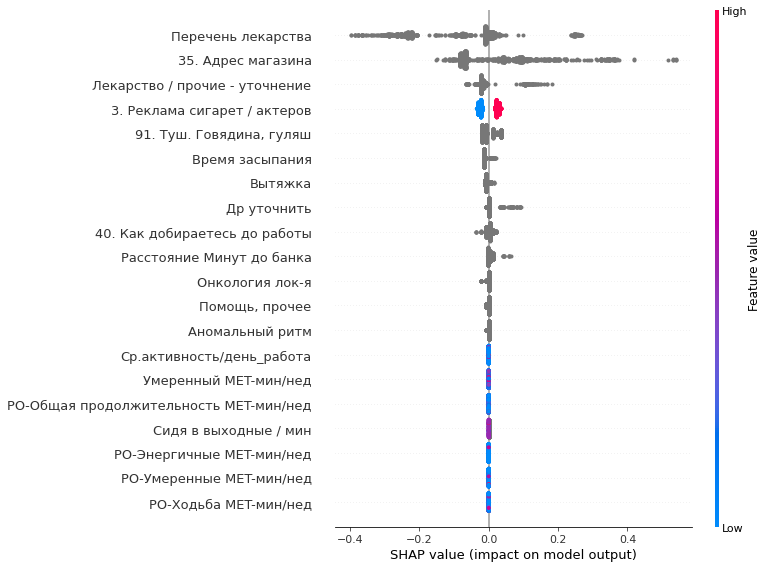

In [422]:
shap.summary_plot(shap_values, train_x)

## Тренировка нашей модели с помощью байссовской оптимизации

In [438]:
cat_pounds = {"n_estimators": (50, 1000), "learning_rate": (-3, 3),
                           "depth": (3, 10), "l2_leaf_reg": (0, 30),
                           "grow_policy": (0, 2), "min_data_in_leaf": (1, 20),
                           "bagging_temperature": (0, 10), "random_strength": (1, 20)
                           }

In [433]:
def cat(n_estimators, learning_rate, depth, l2_leaf_reg, grow_policy, min_data_in_leaf, bagging_temperature,
        random_strength):
    estimator = CatBoostClassifier(
        n_estimators=int(n_estimators),
        learning_rate=100*(10**(-learning_rate)),
        depth=int(depth),
        l2_leaf_reg=l2_leaf_reg,
        random_seed=32,
        grow_policy=['SymmetricTree', 'Depthwise', 'Lossguide'][int(round(grow_policy))],
        min_data_in_leaf=int(min_data_in_leaf),
        bagging_temperature=bagging_temperature,
        random_strength=random_strength,
        verbose=False,
        task_type='GPU',
        cat_features = categorical_features
    )
    return estimator

In [440]:
def cat_cv(**kwargs):
    estim = cat(**kwargs)
    cval = cross_val_score(estim, data_train, data_target[target[4]],
                           scoring=make_scorer(accuracy_score), cv=5)

    return cval.mean()

In [ ]:
optimizer_cat = BayesianOptimization(
            f=cat_cv,
            pbounds=cat_pounds,
            random_state=1234,
            verbose=2
        )
optimizer_cat.maximize(n_iter=100)

In [457]:
dict(data_train.iloc[1])

{'Место проживания 1-город 2-село': 2,
 'Возраст': 69,
 'Вы работаете?': 1,
 'Выход на пенсию': 0,
 'Прекращение работы по болезни': 0,
 'Сахарный диабет': 0,
 'Длительность сахарного диабета': nan,
 'Гепетит': 0,
 'Длительность гепатита ': nan,
 'Онкология': 0,
 'Длительность онкологического процесса': nan,
 'Хроническое заболевание легких': 0,
 'Длительность хрон заболевания легких': nan,
 'Бронжиальная астма': 0,
 'Длительность бронхиальной астмы': nan,
 'Туберкулез легких ': 0,
 'Длительность туберкулеза легких': nan,
 'ВИЧ/СПИД': 0,
 'Длительность ВИЧ/СПИД': nan,
 'Регулярный прим лекарственных средств': 1,
 'Лекарство / давление': 1,
 'Лекарство / холестерин': 0,
 'Лекарство / инсульт': 0,
 'Лекарство / диабет': 0,
 'Лекарство / астма': 0,
 'Лекарство / Китай': 0,
 'Лекарство / прочие': 1,
 'Лекарство / неизвестно': 0,
 'Травмы за год': 0,
 'Переломы': 0,
 'Число перелом': nan,
 'Лет прошло': nan,
 'Возраст курения': nan,
 'Сигарет в день': nan,
 'Сигарет лет': nan,
 'Сигарет пре

In [481]:
with open("sample.json", "w") as outfile:  
    json.dump(new_dict, outfile) 

In [459]:
import json

In [461]:
d = dict(data_train.iloc[1])

In [465]:
json.encoder.JSONEncoder.encode(dict(data_train.iloc[1]), '0')

AttributeError: 'dict' object has no attribute 'ensure_ascii'

In [ ]:
model.predict_proba((pd.read_json('data.json')).values)[1]

In [469]:
model.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [471]:
model.get_feature_importance()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [475]:
model.feature_names_

['Место проживания 1-город 2-село',
 'Возраст',
 'Вы работаете?',
 'Выход на пенсию',
 'Прекращение работы по болезни',
 'Сахарный диабет',
 'Длительность сахарного диабета',
 'Гепетит',
 'Длительность гепатита ',
 'Онкология',
 'Длительность онкологического процесса',
 'Хроническое заболевание легких',
 'Длительность хрон заболевания легких',
 'Бронжиальная астма',
 'Длительность бронхиальной астмы',
 'Туберкулез легких ',
 'Длительность туберкулеза легких',
 'ВИЧ/СПИД',
 'Длительность ВИЧ/СПИД',
 'Регулярный прим лекарственных средств',
 'Лекарство / давление',
 'Лекарство / холестерин',
 'Лекарство / инсульт',
 'Лекарство / диабет',
 'Лекарство / астма',
 'Лекарство / Китай',
 'Лекарство / прочие',
 'Лекарство / неизвестно',
 'Травмы за год',
 'Переломы',
 'Число перелом',
 'Лет прошло',
 'Возраст курения',
 'Сигарет в день',
 'Сигарет лет',
 'Сигарет прекр лет',
 'Сигарет прекр мес',
 'Пассивное курение',
 'Возраст алког',
 'Водка, размер',
 'Водка, порций',
 'Водка, лет',
 'Водка,

In [479]:
new_dict = {}
for x,y in zip(model.feature_names_,model.get_feature_importance()):
    new_dict[x] = y

In [480]:
new_dict

{'Место проживания 1-город 2-село': 0.0,
 'Возраст': 0.0,
 'Вы работаете?': 0.0,
 'Выход на пенсию': 0.0,
 'Прекращение работы по болезни': 0.0,
 'Сахарный диабет': 0.0,
 'Длительность сахарного диабета': 0.0,
 'Гепетит': 0.0,
 'Длительность гепатита ': 0.0,
 'Онкология': 0.0,
 'Длительность онкологического процесса': 0.0,
 'Хроническое заболевание легких': 0.0,
 'Длительность хрон заболевания легких': 0.0,
 'Бронжиальная астма': 0.0,
 'Длительность бронхиальной астмы': 0.0,
 'Туберкулез легких ': 0.0,
 'Длительность туберкулеза легких': 0.0,
 'ВИЧ/СПИД': 0.0,
 'Длительность ВИЧ/СПИД': 0.0,
 'Регулярный прим лекарственных средств': 0.0,
 'Лекарство / давление': 0.0,
 'Лекарство / холестерин': 0.0,
 'Лекарство / инсульт': 0.0,
 'Лекарство / диабет': 0.0,
 'Лекарство / астма': 0.0,
 'Лекарство / Китай': 0.0,
 'Лекарство / прочие': 0.0,
 'Лекарство / неизвестно': 0.0,
 'Травмы за год': 0.0,
 'Переломы': 0.0,
 'Число перелом': 0.0,
 'Лет прошло': 0.0,
 'Возраст курения': 0.0,
 'Сигарет в д